# 改進 SHINE 模型，將 Autoencoder 替換成 lightCGN，並在異質圖上進行資訊傳播

In [1]:
import os
import timeit
import numpy as np
from prepare_data_new import Data
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Embedding, concatenate, Dot, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as bk
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ["path"] += os.pathsep + 'c:/program files (x86)/graphviz2.38/bin'
# saveDir = "C:/Users/user/Google 雲端硬碟/NCKU_NETAI/SHINE/DGE/model"

# 一、讀取資料，包含:
1. Sentiment Graph
2. Social Relation Graph
3. Profile Bipartite Graph

In [3]:
train_ratio = 1
data = Data('data/sentiment.csv',
            'data/social_relation.csv',
            'data/celebrity_profile.csv',
            'data/ordinary_user_profile.csv',
            train_ratio,
            random_state=0)
holders_id_train, targets_id_train, holders_id_test, targets_id_test, holders_sen_adj_train, targets_sen_adj_train, y_train, holders_sen_adj_test, targets_sen_adj_test, y_test, adj_s = data.get_sentiment_data()
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
holders_soc_adj_train, targets_soc_adj_train, holders_soc_adj_test, targets_soc_adj_test, adj_r = data.get_relation_data()
# X1_p_train, X2_p_train, X1_p_test, X2_p_test, adj_o, adj_c = data.get_profile_data()

num_user = adj_s.shape[0]
num_data = len(holders_id_train)
input_dim_adj_vec = holders_sen_adj_train.shape[1]
# input_dim_op = X1_p_train.shape[1]
# input_dim_cp = X2_p_train.shape[1]

print("num of user:", num_user)
print("num of data:", num_data)

num of user: 12814
num of data: 52336


---

# 二、建構模型

## 定義超參數

In [4]:
epoch_size = 5
batch_size = 1000
l2_weight = 0
lambda_proxi = 1
optimizer = Adam(learning_rate=0.001)

EMBEDDING_DIM = 64
n_layers = 1

## 定義 GCN Layer

In [5]:
def create_lightgcn_embed(adj, name, n_layers=3, init_embeddings=None):
    c_adj = bk.constant(adj)
    if init_embeddings is None:
        initializer = tf.initializers.GlorotUniform()
        ego_embeddings = tf.Variable(initializer([num_user, EMBEDDING_DIM]), name=name)
    else:
        ego_embeddings = init_embeddings
    all_embeddings = [ego_embeddings]

    for k in range(0, n_layers):
        #將adj矩陣和ego相乘
        side_embeddings = bk.dot(c_adj, ego_embeddings)
        ego_embeddings = side_embeddings
        all_embeddings += [ego_embeddings]

    # 將每一層 GCN Layer 的結果全部 Concatenate 起來，可以保留不同視野下的資訊並減少 Over-Smooth問題
    all_embeddings = tf.stack(all_embeddings, 1)
    all_embeddings = tf.reduce_mean(all_embeddings, axis=1, keepdims=False)

    return all_embeddings

### 定義幾個 Loss function

In [6]:
# put more weight on non-zero terms
alpha = 10
def reconstruction_loss(y_true, y_pred):
    sqr = bk.square(y_pred - y_true)
    weight = bk.abs(y_true) * (alpha - 1) + 1
    return bk.sum(sqr * weight, axis=-1)

def proximity_loss(y_true, y_pred):
    return bk.sum(-y_pred * y_true, axis=-1)

def proximity_loss_paper(y_true, y_pred):
      return  bk.sum(bk.square(y_true - y_pred))

### 定義模型結構

In [7]:
# placeholder definition
holder_input = Input(name='holder_index_input', shape=(1), dtype=tf.int32)
target_input = Input(name='target_index_input', shape=(1), dtype=tf.int32)

# Use GCN layer to obtain the sentiment embedding table
sen_emb_table = Embedding(num_user,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(
                              create_lightgcn_embed(adj_s, name="sen", n_layers=n_layers)
                          ),
                          trainable=True,
                          input_shape=(None, ))

# Temp Operation: for initialize the weight matrix of embedding layer
sen_emb_table(0)

# Pass sentiment embedding table into social relation GCN
soc_emb_table = Embedding(num_user, 
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(
                              create_lightgcn_embed(adj_r, name="soc", n_layers=n_layers, init_embeddings=sen_emb_table.weights[0])
                          ),
                          trainable=True,
                          input_shape=(None, ))


# Lookup the embedding table to obtain the embeddings of holder and target in both graph
holder_sen_emb = sen_emb_table(holder_input)
target_sen_emb = sen_emb_table(target_input)
holder_soc_emb = soc_emb_table(holder_input)
target_soc_emb = soc_emb_table(target_input)

# dot product of two users
sen_proximity = Dot(axes=-1, normalize=True)([holder_sen_emb, target_sen_emb])
soc_proximity = Dot(axes=-1, normalize=True)([holder_soc_emb, target_soc_emb])


########## Aggregation layer ##########
proximity = Add()([sen_proximity, soc_proximity])

# 訓練用模型
model = Model(inputs=[holder_input, target_input],
              outputs=[proximity])
model.compile(optimizer=optimizer,
              loss=[proximity_loss],
              loss_weights=[1])

# 預測用模型
predict_model = Model(inputs=[holder_input, target_input], outputs=proximity)

# 取得 holder_emb 模型
# holder_agg_emb_model = Model(inputs=[holder_input], outputs=holder_agg_emb)

### 訓練模型

In [8]:
start = timeit.default_timer()
h = model.fit(x=[holders_id_train, targets_id_train],
          y=[y_train],
          epochs=epoch_size,
          batch_size=batch_size,
#           validation_split=0.1)
          validation_data=([holders_id_test, targets_id_test], y_test))
stop = timeit.default_timer()
print('Time: ', stop - start)

Epoch 1/5
53/53 [==============================] - 1s 11ms/step - loss: -0.5379 - val_loss: -0.1300
Epoch 2/5
53/53 [==============================] - 0s 8ms/step - loss: -0.8373 - val_loss: -0.2549
Epoch 3/5
53/53 [==============================] - 0s 7ms/step - loss: -1.0740 - val_loss: -0.3822
Epoch 4/5
53/53 [==============================] - 0s 7ms/step - loss: -1.2750 - val_loss: -0.4727
Epoch 5/5
53/53 [==============================] - 0s 7ms/step - loss: -1.4150 - val_loss: -0.5275
Time:  2.799641540274024


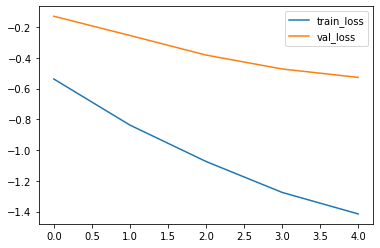

In [9]:
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')

plt.show()

### 效果評估
使用 Metric:
- Accuracy
- Precision
- Recall
- F1-Score
- AUC

In [10]:
def result(X, Y, mode=''):
    # Predict
    y_predict_raw = predict_model.predict(X).flatten()
    y_predict = y_predict_raw.copy()
    y_threshold = np.median(y_predict_raw)
    
    y_predict[y_predict_raw < y_threshold] = -1
    y_predict[y_predict_raw >= y_threshold] = 1
    
    # Calculate Performance
    accuracy = accuracy_score(Y, y_predict)
    f1 = f1_score(Y, y_predict, average='binary')
    AUC = roc_auc_score(Y, y_predict_raw)
    print(mode)
    print(accuracy)
    print(f1)
    print(AUC)
    print()

result(X=[holders_id_train, targets_id_train], Y=y_train, mode='Train')
result(X=[holders_id_test, targets_id_test], Y=y_test, mode='Test')


Train
0.6045551819015591
0.7159172019985724
0.9575857152056898

Test
0.7524590163934426
0.7524590163934426
0.8366165009406075



In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
holder_index_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_index_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        820096      holder_index_input[0][0]         
                                                                 target_index_input[0][0]         
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        820096      holder_index_input[0][